# Capacitated Vehicle Routing Problem

- $n$ is the number of clientes
- $N$ is set of clients, with $N=\{1,2,...,n\}$
- $V$ is set of vetices (or nodes), with $V=\{0\}\cup N$
- $A$ is set of arcs, with $A=\{(i,j)\in V^2 : i\neq j\}$
- $c_{ij}$ is cost of travel over arc $(i,j)\in A$
- $Q$ is the vehicle capacity
- $q_i$ is the amount that has to be delivered to customer $i\in N$

Then, the formulation is the following
$$\begin{align}
\min \quad & \sum_{i,j\in A} c_{ij} x_{ij} \\
\text{s.t.} \quad & \sum_{j\in V , j\neq i} x_{ij} = 1  && i \in N \\
& \sum_{i\in V , i\neq j} x_{ij} = 1 && j \in N \\
& \text{if} \ x_{ij}=1 \ \Rightarrow \ u_i + q_j = u_j && i,j \in A : j\neq 0, i\neq 0 \\
& q_i \leq u_i \leq Q && i \in N \\
& x_{ij} \in \{0,1\} && i,j \in A
\end{align}$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

In [2]:
file_path = 'dataset.txt'
column_names = ["CUST NO.", "XCOORD.", "YCOORD.", "DEMAND", "READY TIME", "DUE DATE", "SERVICE TIME"]

df = pd.read_csv(file_path, delim_whitespace=True, names=column_names)

number_of_customers=25
df = df.head(number_of_customers+1)

df.head()

,CUST NO.,XCOORD.,YCOORD.,DEMAND,READY TIME,DUE DATE,SERVICE TIME
0,1,35.0,35.0,0.0,0.0,230.0,0.0
1,2,41.0,49.0,10.0,161.0,171.0,10.0
2,3,35.0,17.0,7.0,50.0,60.0,10.0
3,4,55.0,45.0,13.0,116.0,126.0,10.0
4,5,55.0,20.0,19.0,149.0,159.0,10.0


In [3]:
xc = df['XCOORD.'].values
yc = df['YCOORD.'].values

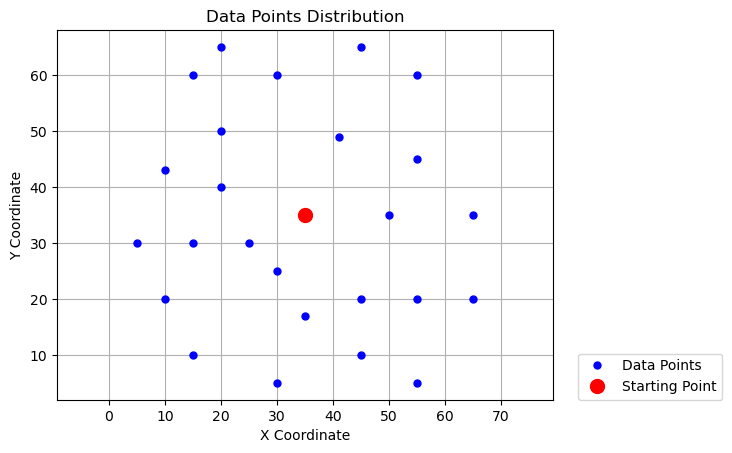

In [4]:
plt.plot(df["XCOORD."], df["YCOORD."], ".", color="blue", markersize=10, label="Data Points")
plt.plot(df["XCOORD."][0], df["YCOORD."][0], "o", color="red", markersize=10, label="Starting Point")

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Data Points Distribution")

plt.xlim(0)
plt.ylim(0)
plt.axis('equal')

plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
plt.show()

In [5]:
n = len(df)-1
N = [i for i in range(1, n+1)]
V = [0] + N
A = [(i, j) for i in V for j in V if i != j]
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}
st = df['SERVICE TIME'].values
t = {(i,j): c[(i,j)] + st[j] for i, j in A}
Q = 200
q = df['DEMAND'].values

In [6]:
mdl = Model('CVRP')

In [14]:
x = mdl.binary_var_dict(A, name='x') # (6)
u = mdl.continuous_var_dict(N, ub=Q, name='u')
s = mdl.continuous_var_dic( vehicles , nodes , name = 'service_time')

AttributeError: 'Model' object has no attribute 'continuous_var_dic'

In [9]:
mdl.minimize(mdl.sum(t[i, j]*x[i, j] for i, j in A)) # Objective Function
mdl.add_constraints(mdl.sum(x[i, j] for j in V if j != i) == 1 for i in N) # Routing (2)
mdl.add_constraints(mdl.sum(x[i, j] for i in V if i != j) == 1 for j in N) # Rputing (3)
mdl.add_indicator_constraints(mdl.indicator_constraint(x[i, j], u[i]+q[j] == u[j]) for i, j in A if i != 0 and j != 0) # (4)
mdl.add_constraints(u[i] >= q[i] for i in N) # Capacity (5)
mdl.parameters.timelimit = 60
solution = mdl.solve(log_output=True)

Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               60
Found incumbent of value 1496.160180 after 0.00 sec. (0.06 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 25 rows and 0 columns.
MIP Presolve modified 300 coefficients.
Aggregator did 300 substitutions.
Reduced MIP has 350 rows, 975 columns, and 2150 nonzeros.
Reduced MIP has 650 binaries, 0 generals, 0 SOSs, and 600 indicators.
Presolve time = 0.03 sec. (2.69 ticks)
Probing time = 0.03 sec. (5.07 ticks)


Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 350 rows, 975 columns, and 2150 nonzeros.
Reduced MIP has 650 binaries, 0 generals, 0 SOSs, and 600 indicators.
Presolve time = 0.02 sec. (1.53 ticks)
Probing time = 0.02 sec. (2.29 ticks)
Clique table members: 350.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.78 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                         1496.1602        0.0000           100.00%
      0     0      527.4866    25     1496.1602      527.4866       34   64.74%
      0     0      545.9763    34     1496.1602      Cuts: 49       71   63.51%
      0     0      548.5832    33     1496.1602      Cuts: 16       90   63.33%
      0     0      548.5832    47     1496.1602      Cuts: 18   

In [10]:
print(solution)

solution for: CVRP
objective: 585.269
status: FEASIBLE_SOLUTION(1)
x_0_1=1
x_0_12=1
x_1_9=1
x_2_15=1
x_3_24=1
x_4_23=1
x_5_0=1
x_6_13=1
x_7_8=1
x_8_18=1
x_9_20=1
x_10_11=1
x_11_19=1
x_12_3=1
x_13_0=1
x_14_16=1
x_15_14=1
x_16_17=1
x_17_5=1
x_18_6=1
x_19_7=1
x_20_10=1
x_21_2=1
x_22_21=1
x_23_22=1
x_24_25=1
x_25_4=1
u_1=10.000
u_2=125.000
u_3=32.000
u_4=60.000
u_5=200.000
u_6=109.000
u_7=85.000
u_8=94.000
u_9=26.000
u_10=51.000
u_11=63.000
u_12=19.000
u_13=132.000
u_14=153.000
u_15=133.000
u_16=172.000
u_17=174.000
u_18=106.000
u_19=80.000
u_20=35.000
u_21=118.000
u_22=107.000
u_23=89.000
u_24=35.000
u_25=41.000



In [11]:
solution.solve_status

<JobSolveStatus.FEASIBLE_SOLUTION: 1>

In [12]:
active_arcs = [a for a in A if x[a].solution_value > 0.9]

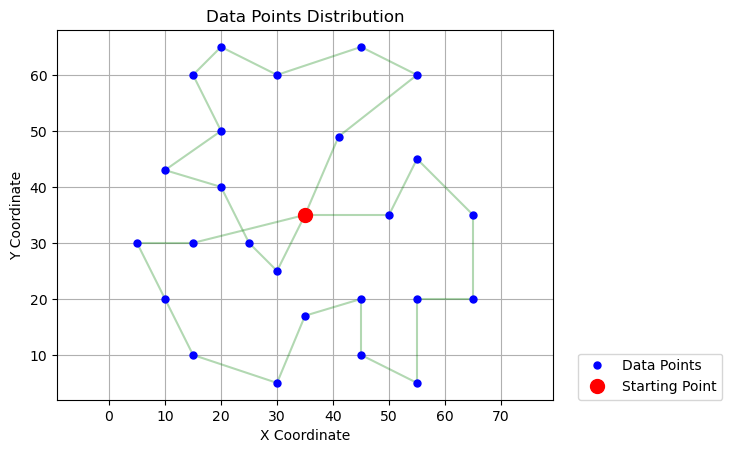

In [13]:
for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', alpha=0.3)

plt.plot(df["XCOORD."], df["YCOORD."], ".", color="blue", markersize=10, label="Data Points")
plt.plot(df["XCOORD."][0], df["YCOORD."][0], "o", color="red", markersize=10, label="Starting Point")

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Data Points Distribution")

plt.xlim(0)
plt.ylim(0)
plt.axis('equal')

plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
plt.show()